# Stock Market Prediction And Forecasting Using Stacked LSTM

Using Keras and Tensorflow

Dataset
Yahoo Finance - Stock of Reliance Industries Limited NSE: RELIANCE: https://finance.yahoo.com/quote/RELIANCE.NS/history?period1=1433635200&period2=1591488000&interval=1d&filter=history&frequency=1d

In [1]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

Read the Data from .csv file

In [2]:
#Import the data and remove rows containing NAN values
df = pd.read_csv('Stocks.csv')

Display Data

In [3]:
df = df.dropna()
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,28-09-2018,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,27-09-2018,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,26-09-2018,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,25-09-2018,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,24-09-2018,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,27-07-2010,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,26-07-2010,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,23-07-2010,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,22-07-2010,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,21-07-2010,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [5]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [6]:
df_close=df['Close']

In [7]:
df_close.shape

(2035,)

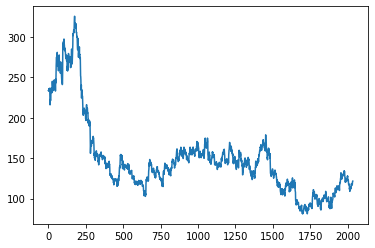

In [8]:
plt.plot(df_close)

Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [10]:
df_close.shape

(2035, 1)

In [11]:
df_close

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [12]:
#Split the data into train and test split
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]
#train_data, test_data = train_test_split(df_close,test_size=0.4)

In [13]:
train_data, test_data

(array([[0.62418301],
        [0.62214052],
        [0.62622549],
        ...,
        [0.18831699],
        [0.18811275],
        [0.17034314]]),
 array([[0.1621732 ],
        [0.15972222],
        [0.16278595],
        [0.17340686],
        [0.14174837],
        [0.15441176],
        [0.16503268],
        [0.15563725],
        [0.14460784],
        [0.13684641],
        [0.13582516],
        [0.14072712],
        [0.14501634],
        [0.14195261],
        [0.13562092],
        [0.15053105],
        [0.15727124],
        [0.15461601],
        [0.15767974],
        [0.15114379],
        [0.14297386],
        [0.14215686],
        [0.14787582],
        [0.13970588],
        [0.11642157],
        [0.11131536],
        [0.10927288],
        [0.10334967],
        [0.09783497],
        [0.10089869],
        [0.10906863],
        [0.10171569],
        [0.11254085],
        [0.12704248],
        [0.12214052],
        [0.12704248],
        [0.11519608],
        [0.11008987],
        [0.099673

In [14]:
training_size,test_size

(1526, 509)

In [15]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [17]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [18]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 24s 448ms/step - loss: 0.0596 - val_loss: 0.0074
Epoch 2/100
23/23 [==============================] - 8s 344ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 3/100
23/23 [==============================] - 8s 343ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/100
23/23 [==============================] - 8s 347ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/100
23/23 [==============================] - 8s 348ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/100
23/23 [==============================] - 8s 351ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
23/23 [==============================] - 8s 342ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/100
23/23 [==============================] - 8s 344ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/100
23/23 [==============================] - 8s 342ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100
23/23 [==============================] - 8s 342ms/step - loss: 0.0011 - val_l

23/23 [==============================] - 8s 330ms/step - loss: 2.8845e-04 - val_loss: 2.0333e-04
Epoch 77/100
23/23 [==============================] - 8s 329ms/step - loss: 3.1572e-04 - val_loss: 4.5344e-04
Epoch 78/100
23/23 [==============================] - 8s 328ms/step - loss: 2.7783e-04 - val_loss: 2.3403e-04
Epoch 79/100
23/23 [==============================] - 8s 327ms/step - loss: 2.3297e-04 - val_loss: 2.3233e-04
Epoch 80/100
23/23 [==============================] - 7s 326ms/step - loss: 2.4026e-04 - val_loss: 2.2138e-04
Epoch 81/100
23/23 [==============================] - 8s 330ms/step - loss: 2.2483e-04 - val_loss: 2.6825e-04
Epoch 82/100
23/23 [==============================] - 8s 332ms/step - loss: 2.2270e-04 - val_loss: 2.3626e-04
Epoch 83/100
23/23 [==============================] - 8s 330ms/step - loss: 3.5987e-04 - val_loss: 2.9062e-04
Epoch 84/100
23/23 [==============================] - 8s 332ms/step - loss: 2.6412e-04 - val_loss: 1.9103e-04
Epoch 85/100
23/23 [===

In [22]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [23]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

163.3336065635827

In [25]:
math.sqrt(mean_squared_error(y_test, test_predict))

104.69712939028624

# Plotting

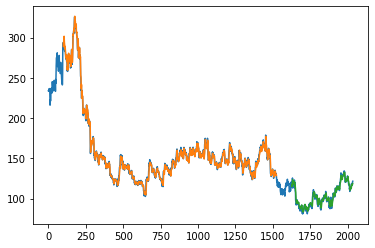

In [26]:
#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


# Predict Next 30 days of Stock Price

In [27]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [28]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 302)

In [29]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [33]:
lst_output=[]
n_steps=301
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.07148693 0.08721405 0.08986928 0.10498366 0.08905229 0.10355392
 0.10375817 0.12275327 0.10906863 0.09660948 0.1064134  0.10457516
 0.11049837 0.1127451  0.09803922 0.09987745 0.08925654 0.0747549
 0.08169935 0.08925654 0.09068627 0.08129085 0.08823529 0.08455882
 0.07945261 0.08374183 0.07781863 0.09824346 0.09089052 0.09007353
 0.09558824 0.06862745 0.06372549 0.0494281  0.04799837 0.04534314
 0.0443219  0.03941993 0.0379902  0.04656863 0.05085784 0.07209967
 0.06535948 0.07230392 0.07802288 0.07741013 0.06086601 0.06413399
 0.07046569 0.05412582 0.0498366  0.05167484 0.05330882 0.0435049
 0.02634804 0.02410131 0.02961601 0.01960784 0.02961601 0.04575163
 0.05923203 0.06678922 0.06229575 0.06311275 0.0629085  0.06658497
 0.07434641 0.06944444 0.08088235 0.07700163 0.0684232  0.06781046
 0.0629085  0.0692402  0.0755719  0.07781863 0.08088235 0.08843954
 0.09395425 0.09599673 0.08660131 0.09027778 0.08517157 0.08374183
 0.07945261 0.09109477 0.09129902 0.08803105 0.09681

3 day output [[0.14524007]]
4 day input [0.08905229 0.10355392 0.10375817 0.12275327 0.10906863 0.09660948
 0.1064134  0.10457516 0.11049837 0.1127451  0.09803922 0.09987745
 0.08925654 0.0747549  0.08169935 0.08925654 0.09068627 0.08129085
 0.08823529 0.08455882 0.07945261 0.08374183 0.07781863 0.09824346
 0.09089052 0.09007353 0.09558824 0.06862745 0.06372549 0.0494281
 0.04799837 0.04534314 0.0443219  0.03941993 0.0379902  0.04656863
 0.05085784 0.07209967 0.06535948 0.07230392 0.07802288 0.07741013
 0.06086601 0.06413399 0.07046569 0.05412582 0.0498366  0.05167484
 0.05330882 0.0435049  0.02634804 0.02410131 0.02961601 0.01960784
 0.02961601 0.04575163 0.05923203 0.06678922 0.06229575 0.06311275
 0.0629085  0.06658497 0.07434641 0.06944444 0.08088235 0.07700163
 0.0684232  0.06781046 0.0629085  0.0692402  0.0755719  0.07781863
 0.08088235 0.08843954 0.09395425 0.09599673 0.08660131 0.09027778
 0.08517157 0.08374183 0.07945261 0.09109477 0.09129902 0.08803105
 0.09681373 0.11417484 

6 day output [[0.14432734]]
7 day input [0.12275327 0.10906863 0.09660948 0.1064134  0.10457516 0.11049837
 0.1127451  0.09803922 0.09987745 0.08925654 0.0747549  0.08169935
 0.08925654 0.09068627 0.08129085 0.08823529 0.08455882 0.07945261
 0.08374183 0.07781863 0.09824346 0.09089052 0.09007353 0.09558824
 0.06862745 0.06372549 0.0494281  0.04799837 0.04534314 0.0443219
 0.03941993 0.0379902  0.04656863 0.05085784 0.07209967 0.06535948
 0.07230392 0.07802288 0.07741013 0.06086601 0.06413399 0.07046569
 0.05412582 0.0498366  0.05167484 0.05330882 0.0435049  0.02634804
 0.02410131 0.02961601 0.01960784 0.02961601 0.04575163 0.05923203
 0.06678922 0.06229575 0.06311275 0.0629085  0.06658497 0.07434641
 0.06944444 0.08088235 0.07700163 0.0684232  0.06781046 0.0629085
 0.0692402  0.0755719  0.07781863 0.08088235 0.08843954 0.09395425
 0.09599673 0.08660131 0.09027778 0.08517157 0.08374183 0.07945261
 0.09109477 0.09129902 0.08803105 0.09681373 0.11417484 0.10498366
 0.09987745 0.08537582 0

9 day output [[0.143454]]
10 day input [0.1064134  0.10457516 0.11049837 0.1127451  0.09803922 0.09987745
 0.08925654 0.0747549  0.08169935 0.08925654 0.09068627 0.08129085
 0.08823529 0.08455882 0.07945261 0.08374183 0.07781863 0.09824346
 0.09089052 0.09007353 0.09558824 0.06862745 0.06372549 0.0494281
 0.04799837 0.04534314 0.0443219  0.03941993 0.0379902  0.04656863
 0.05085784 0.07209967 0.06535948 0.07230392 0.07802288 0.07741013
 0.06086601 0.06413399 0.07046569 0.05412582 0.0498366  0.05167484
 0.05330882 0.0435049  0.02634804 0.02410131 0.02961601 0.01960784
 0.02961601 0.04575163 0.05923203 0.06678922 0.06229575 0.06311275
 0.0629085  0.06658497 0.07434641 0.06944444 0.08088235 0.07700163
 0.0684232  0.06781046 0.0629085  0.0692402  0.0755719  0.07781863
 0.08088235 0.08843954 0.09395425 0.09599673 0.08660131 0.09027778
 0.08517157 0.08374183 0.07945261 0.09109477 0.09129902 0.08803105
 0.09681373 0.11417484 0.10498366 0.09987745 0.08537582 0.08047386
 0.06862745 0.06576797 0

12 day output [[0.14262027]]
13 day input [0.1127451  0.09803922 0.09987745 0.08925654 0.0747549  0.08169935
 0.08925654 0.09068627 0.08129085 0.08823529 0.08455882 0.07945261
 0.08374183 0.07781863 0.09824346 0.09089052 0.09007353 0.09558824
 0.06862745 0.06372549 0.0494281  0.04799837 0.04534314 0.0443219
 0.03941993 0.0379902  0.04656863 0.05085784 0.07209967 0.06535948
 0.07230392 0.07802288 0.07741013 0.06086601 0.06413399 0.07046569
 0.05412582 0.0498366  0.05167484 0.05330882 0.0435049  0.02634804
 0.02410131 0.02961601 0.01960784 0.02961601 0.04575163 0.05923203
 0.06678922 0.06229575 0.06311275 0.0629085  0.06658497 0.07434641
 0.06944444 0.08088235 0.07700163 0.0684232  0.06781046 0.0629085
 0.0692402  0.0755719  0.07781863 0.08088235 0.08843954 0.09395425
 0.09599673 0.08660131 0.09027778 0.08517157 0.08374183 0.07945261
 0.09109477 0.09129902 0.08803105 0.09681373 0.11417484 0.10498366
 0.09987745 0.08537582 0.08047386 0.06862745 0.06576797 0.06147876
 0.07169118 0.07026144

16 day output [[0.14156917]]
17 day input [0.0747549  0.08169935 0.08925654 0.09068627 0.08129085 0.08823529
 0.08455882 0.07945261 0.08374183 0.07781863 0.09824346 0.09089052
 0.09007353 0.09558824 0.06862745 0.06372549 0.0494281  0.04799837
 0.04534314 0.0443219  0.03941993 0.0379902  0.04656863 0.05085784
 0.07209967 0.06535948 0.07230392 0.07802288 0.07741013 0.06086601
 0.06413399 0.07046569 0.05412582 0.0498366  0.05167484 0.05330882
 0.0435049  0.02634804 0.02410131 0.02961601 0.01960784 0.02961601
 0.04575163 0.05923203 0.06678922 0.06229575 0.06311275 0.0629085
 0.06658497 0.07434641 0.06944444 0.08088235 0.07700163 0.0684232
 0.06781046 0.0629085  0.0692402  0.0755719  0.07781863 0.08088235
 0.08843954 0.09395425 0.09599673 0.08660131 0.09027778 0.08517157
 0.08374183 0.07945261 0.09109477 0.09129902 0.08803105 0.09681373
 0.11417484 0.10498366 0.09987745 0.08537582 0.08047386 0.06862745
 0.06576797 0.06147876 0.07169118 0.07026144 0.0747549  0.06821895
 0.0692402  0.07066993

19 day output [[0.14082485]]
20 day input [0.09068627 0.08129085 0.08823529 0.08455882 0.07945261 0.08374183
 0.07781863 0.09824346 0.09089052 0.09007353 0.09558824 0.06862745
 0.06372549 0.0494281  0.04799837 0.04534314 0.0443219  0.03941993
 0.0379902  0.04656863 0.05085784 0.07209967 0.06535948 0.07230392
 0.07802288 0.07741013 0.06086601 0.06413399 0.07046569 0.05412582
 0.0498366  0.05167484 0.05330882 0.0435049  0.02634804 0.02410131
 0.02961601 0.01960784 0.02961601 0.04575163 0.05923203 0.06678922
 0.06229575 0.06311275 0.0629085  0.06658497 0.07434641 0.06944444
 0.08088235 0.07700163 0.0684232  0.06781046 0.0629085  0.0692402
 0.0755719  0.07781863 0.08088235 0.08843954 0.09395425 0.09599673
 0.08660131 0.09027778 0.08517157 0.08374183 0.07945261 0.09109477
 0.09129902 0.08803105 0.09681373 0.11417484 0.10498366 0.09987745
 0.08537582 0.08047386 0.06862745 0.06576797 0.06147876 0.07169118
 0.07026144 0.0747549  0.06821895 0.0692402  0.07066993 0.06801471
 0.06678922 0.0741421

22 day output [[0.14011656]]
23 day input [0.08455882 0.07945261 0.08374183 0.07781863 0.09824346 0.09089052
 0.09007353 0.09558824 0.06862745 0.06372549 0.0494281  0.04799837
 0.04534314 0.0443219  0.03941993 0.0379902  0.04656863 0.05085784
 0.07209967 0.06535948 0.07230392 0.07802288 0.07741013 0.06086601
 0.06413399 0.07046569 0.05412582 0.0498366  0.05167484 0.05330882
 0.0435049  0.02634804 0.02410131 0.02961601 0.01960784 0.02961601
 0.04575163 0.05923203 0.06678922 0.06229575 0.06311275 0.0629085
 0.06658497 0.07434641 0.06944444 0.08088235 0.07700163 0.0684232
 0.06781046 0.0629085  0.0692402  0.0755719  0.07781863 0.08088235
 0.08843954 0.09395425 0.09599673 0.08660131 0.09027778 0.08517157
 0.08374183 0.07945261 0.09109477 0.09129902 0.08803105 0.09681373
 0.11417484 0.10498366 0.09987745 0.08537582 0.08047386 0.06862745
 0.06576797 0.06147876 0.07169118 0.07026144 0.0747549  0.06821895
 0.0692402  0.07066993 0.06801471 0.06678922 0.07414216 0.07169118
 0.08639706 0.08312908

 0.13966361]
25 day output [[0.13944273]]
26 day input [0.07781863 0.09824346 0.09089052 0.09007353 0.09558824 0.06862745
 0.06372549 0.0494281  0.04799837 0.04534314 0.0443219  0.03941993
 0.0379902  0.04656863 0.05085784 0.07209967 0.06535948 0.07230392
 0.07802288 0.07741013 0.06086601 0.06413399 0.07046569 0.05412582
 0.0498366  0.05167484 0.05330882 0.0435049  0.02634804 0.02410131
 0.02961601 0.01960784 0.02961601 0.04575163 0.05923203 0.06678922
 0.06229575 0.06311275 0.0629085  0.06658497 0.07434641 0.06944444
 0.08088235 0.07700163 0.0684232  0.06781046 0.0629085  0.0692402
 0.0755719  0.07781863 0.08088235 0.08843954 0.09395425 0.09599673
 0.08660131 0.09027778 0.08517157 0.08374183 0.07945261 0.09109477
 0.09129902 0.08803105 0.09681373 0.11417484 0.10498366 0.09987745
 0.08537582 0.08047386 0.06862745 0.06576797 0.06147876 0.07169118
 0.07026144 0.0747549  0.06821895 0.0692402  0.07066993 0.06801471
 0.06678922 0.07414216 0.07169118 0.08639706 0.08312908 0.06311275
 0.06290

28 day output [[0.13880178]]
29 day input [0.09007353 0.09558824 0.06862745 0.06372549 0.0494281  0.04799837
 0.04534314 0.0443219  0.03941993 0.0379902  0.04656863 0.05085784
 0.07209967 0.06535948 0.07230392 0.07802288 0.07741013 0.06086601
 0.06413399 0.07046569 0.05412582 0.0498366  0.05167484 0.05330882
 0.0435049  0.02634804 0.02410131 0.02961601 0.01960784 0.02961601
 0.04575163 0.05923203 0.06678922 0.06229575 0.06311275 0.0629085
 0.06658497 0.07434641 0.06944444 0.08088235 0.07700163 0.0684232
 0.06781046 0.0629085  0.0692402  0.0755719  0.07781863 0.08088235
 0.08843954 0.09395425 0.09599673 0.08660131 0.09027778 0.08517157
 0.08374183 0.07945261 0.09109477 0.09129902 0.08803105 0.09681373
 0.11417484 0.10498366 0.09987745 0.08537582 0.08047386 0.06862745
 0.06576797 0.06147876 0.07169118 0.07026144 0.0747549  0.06821895
 0.0692402  0.07066993 0.06801471 0.06678922 0.07414216 0.07169118
 0.08639706 0.08312908 0.06311275 0.0629085  0.05167484 0.03186275
 0.04003268 0.03860294

In [34]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [35]:
df3 = df_close.tolist()
df3.extend(lst_output)

In [36]:
len(df_close)

2035

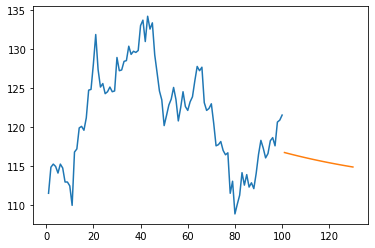

In [39]:
plt.plot(day_new, scaler.inverse_transform(df_close[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))